# Homework 6: Predictive Regression - Jingwen Li

In [140]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import nasdaqdatalink as ndl
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm, pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
import statsmodels.regression.linear_model as linreg

## 1. Obtaining Data

### a. read 5 year CDS rates and calculate weekly CDS return and index return


In [2]:
df = pd.read_csv("Liq5YCDS.delim", delimiter = '\t')
df.set_index('date', inplace = True)

In [3]:
df = df.iloc[:,1:]
df

,ticker,tenor,parspread,upfront,runningcoupon,cdsrealrecovery,cdsassumedrecovery,docclause,currency,tier,impliedrating
date,,,,,,,,,,,
2018-01-01,BA,5Y,0.001793,-0.038914,0.01,0.400000,0.4,MR14,USD,SNRFOR,BBB
2018-01-01,C,5Y,0.004113,-0.027708,0.01,0.400000,0.4,MR14,USD,SNRFOR,A
2018-01-01,DD,5Y,0.002476,-0.035641,0.01,0.400000,0.4,MR14,USD,SNRFOR,A
2018-01-01,F,5Y,0.008805,-0.192592,0.05,0.390000,0.4,MR14,USD,SNRFOR,BB
2018-01-01,GE,5Y,0.004037,-0.028103,0.01,0.400000,0.4,MR14,USD,SNRFOR,BBB
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,NFLX,5Y,0.014090,0.017825,0.01,0.396650,0.4,MR14,USD,SNRFOR,BBB
2022-12-30,T,5Y,0.011370,0.006043,0.01,0.396667,0.4,MR14,USD,SNRFOR,BBB
2022-12-30,WFC,5Y,0.008301,-0.184861,0.05,0.400000,0.4,MR14,USD,SNRFOR,A


In [4]:
parspread = df.pivot_table(values='parspread', columns='ticker', index=df.index)
parspread.index = pd.to_datetime(parspread.index)
R_cds = parspread.resample('W-WED').last()
R_cds = R_cds.pct_change()
R_cds

ticker,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,-0.057555,-0.002449,0.012286,0.017203,0.009527,0.028725,-0.021380,-0.073064,0.045735,0.036897,NaN,-0.000253,0.002160,-0.011199,-0.100206
2018-01-17,0.090416,-0.004649,0.046848,0.093586,0.154969,-0.020475,0.010851,0.449611,0.069635,0.137440,NaN,0.000701,0.003072,-0.019352,-0.208152
2018-01-24,0.004652,0.006147,0.059232,0.074893,0.256980,-0.000440,0.001468,0.206392,0.073706,0.010891,NaN,-0.001168,-0.011792,-0.031147,0.117619
2018-01-31,-0.016092,-0.018857,0.037755,0.026133,-0.007615,-0.020960,-0.002848,0.061483,0.030513,-0.071606,NaN,0.000574,-0.008457,0.003994,-0.448593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07,0.029472,0.043013,0.070689,0.078495,0.067518,0.048463,-0.001796,0.070621,0.047890,0.042948,0.085617,-0.012027,0.052216,0.000723,0.021388
2022-12-14,-0.075277,-0.066410,-0.128885,-0.003357,-0.066738,-0.054943,0.003431,-0.108076,-0.082289,-0.077516,-0.089302,-0.017441,-0.054341,0.000176,-0.077466
2022-12-21,0.090760,0.082415,0.120199,0.089722,0.137151,0.099092,0.174270,0.058703,0.090155,0.102110,0.146294,0.008605,0.102911,-0.000313,0.059923


In [5]:
R_index = R_cds.mean(axis=1).to_frame('cds_index')
R_index

,cds_index
date,
2018-01-03,NaN
2018-01-10,-0.008112
2018-01-17,0.057464
2018-01-24,0.054817
2018-01-31,-0.031041
...,...
2022-12-07,0.043015
2022-12-14,-0.059896
2022-12-21,0.090800


### b. load the corresponding adjusted close prices for the corresponding equity and SPY, and calculate the weekly return

In [6]:
df_prices = pd.DataFrame()

quandl.ApiConfig.api_key = "key"

sdate, edate = '2017-12-31', '2023-02-15'

tickers = ['BA','C','DD','F','GE','JPM','LNC','LOW','LUV','MAR','NFLX','T','WFC','XOM','XRX','SPY']

for i in tickers:
    data = quandl.get_table("QUOTEMEDIA/PRICES", qopts = { 'columns': ['date', 'adj_close']}, date = { 'gte': sdate, 'lte': edate }, ticker=i)
    data = data.rename(columns={'adj_close': i})
    data = data.set_index('date')
    data.index = pd.to_datetime(data.index)
    
    if df_prices.empty:
        df_prices = data
    else:
        try:
            df_prices = pd.concat([df_prices, data], axis=1, verify_integrity=True)
        except ValueError as e:
            print(f"Error: Indices do not line up in data for ticker {i}.")
            raise e

df_prices = df_prices.iloc[::-1]

In [7]:
df_prices = df_prices.resample('W-WED').last()
df_ret = df_prices.pct_change()
R_equity = df_ret.iloc[:,:-1]
R_equity

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,0.075420,0.014211,0.015743,0.021160,0.042920,0.025506,0.071882,0.023364,-0.030042,0.009161,0.036430,-0.014385,0.025341,-0.007151,0.034777
2018-01-17,0.096016,0.024058,0.021159,-0.065234,-0.083417,0.024853,0.002295,0.079749,0.049396,0.031227,0.023433,0.006281,0.012041,0.022305,0.051730
2018-01-24,-0.046494,0.025558,0.003167,-0.010673,-0.052450,0.023719,0.004338,0.053585,-0.058423,0.016831,0.201379,0.004613,0.025047,0.006023,0.013784
2018-01-31,0.058801,-0.012209,-0.005657,-0.066703,-0.016423,0.000000,-0.006479,-0.018647,-0.022665,0.020431,0.034443,0.011615,0.004582,-0.013894,0.054697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-18,0.006634,0.014781,-0.022964,-0.061271,0.020337,-0.021915,-0.054897,-0.000431,0.009174,0.008330,-0.002842,-0.020093,0.014974,-0.006824,0.011446
2023-01-25,0.015615,0.049970,0.004783,0.030620,0.019175,0.018672,0.082508,-0.006434,0.015702,0.078478,0.127570,0.073607,0.045182,0.023506,0.037522
2023-02-01,0.009733,0.004817,0.008296,0.078186,0.018938,0.003378,0.050915,0.036146,-0.033632,0.017583,-0.016225,-0.011753,0.043891,0.013515,-0.041332


In [8]:
R_spy = df_ret.iloc[:,-1:]
R_spy

,SPY
date,
2018-01-03,NaN
2018-01-10,0.013495
2018-01-17,0.020028
2018-01-24,0.012768
2018-01-31,-0.004520
...,...
2023-01-18,-0.010189
2023-01-25,0.022631
2023-02-01,0.026102


In [127]:
df_return = df_ret.merge(R_cds, left_index=True, right_index=True, suffixes=["_eq","_cds"])
returns = df_return.merge(R_index, left_index=True, right_index=True)

### c. plot both cds return and equity return, and correlation

Text(0.5, 1.0, 'CDS spread return')

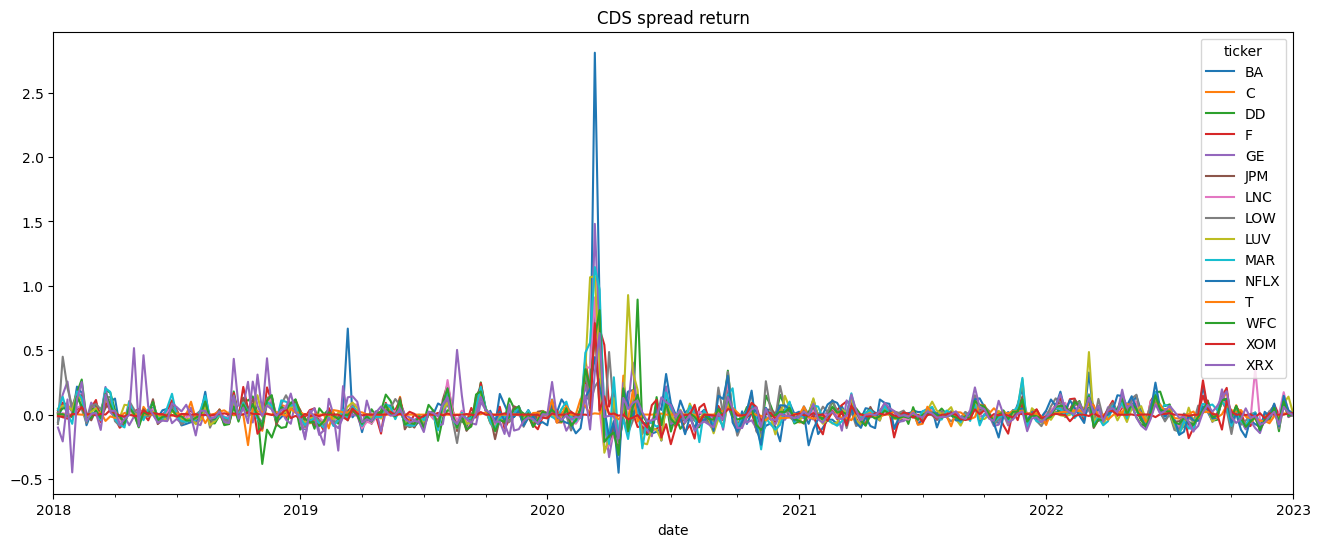

In [10]:
R_cds.plot(figsize=(16, 6))
plt.title('CDS spread return')

Text(0.5, 1.0, 'Stock return')

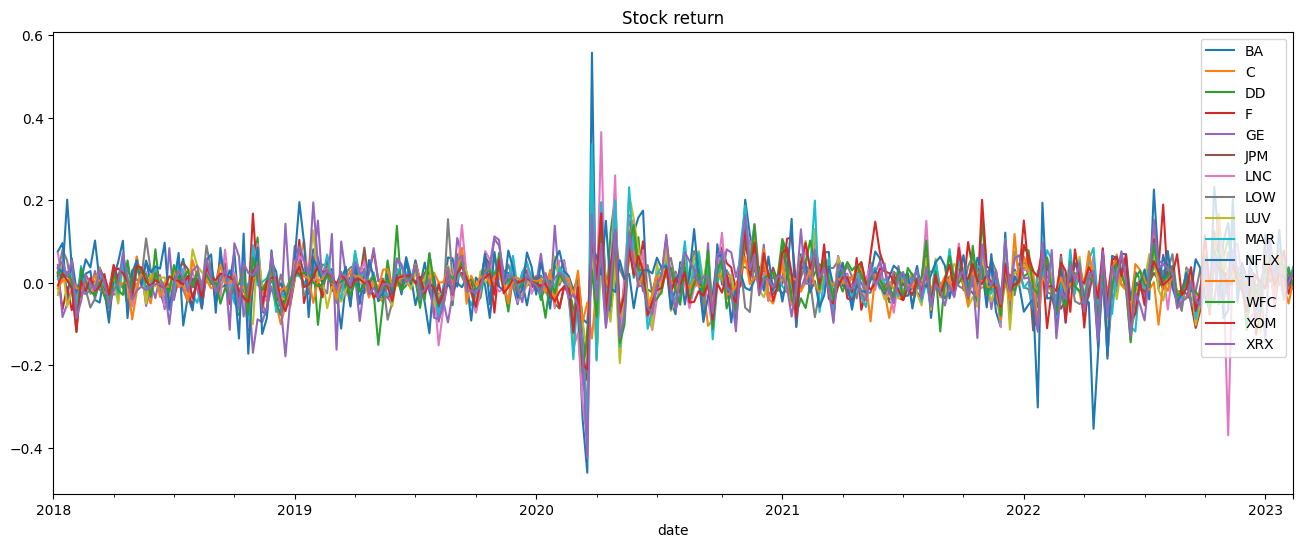

In [11]:
R_equity.plot(figsize=(16, 6))
plt.title('Stock return')

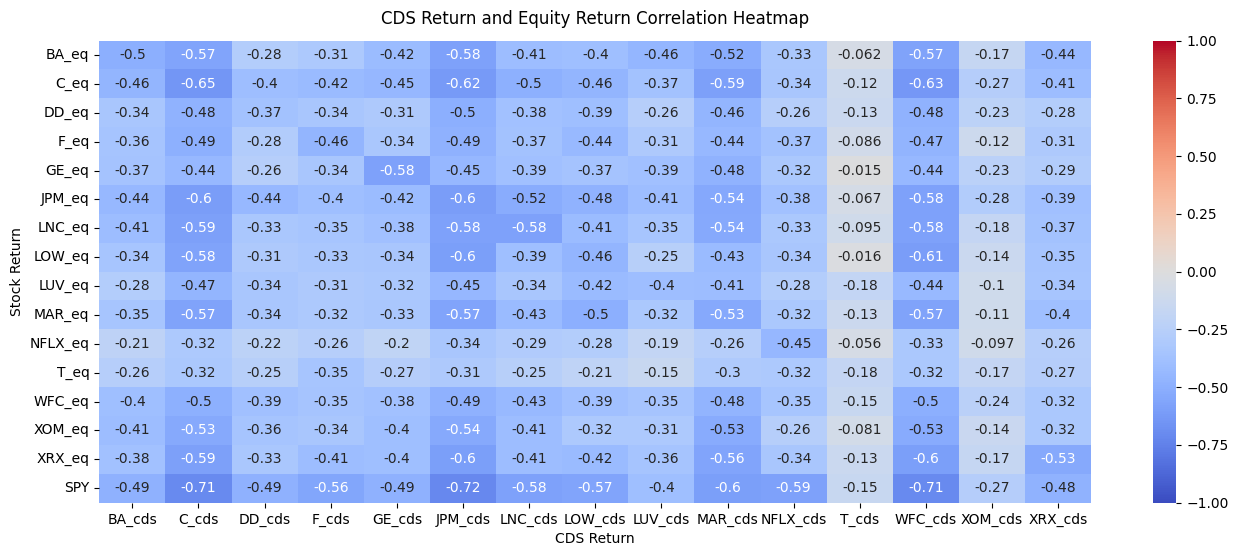

In [12]:

corr1 = df_return.corr().iloc[:16,16:]
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr1,  vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.xlabel('CDS Return')
plt.ylabel('Stock Return')
heatmap.set_title('CDS Return and Equity Return Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Comment:

From the correlations heatmap we can see that there is a weak linear relationship between the two returns. A correlation coefficient between -0.72 and 0 indicates that the two variables are negatively correlated. A general negative correlation coefficient indicates that they tend to move in opposite directions. 

This makes sense, since when a company performs well, investors are likely to have greater confidence in the company's ability to meet its financial obligations, such as paying its debts. This can lead to a lower perceived risk of default, which in turn can lead to a lower CDS spread (i.e., a smaller return on CDS). Conversely, if a company's financial health is perceived to be deteriorating, investors may view it as more risky, and demand a higher return on CDS to compensate for this perceived risk.

The stock return and CDS spread are both influenced by the company's financial health, but they measure different aspects of it. The stock return reflects the market's expectations of the company's future profitability, growth prospects, and overall financial performance. The CDS spread, on the other hand, measures the perceived risk of default on the company's debt obligations.

## 2. Models

### 2.1.a. Boxcar regression:
#### $ r_{E}^{CDS} ∼ r_{E}^{Equity} + r_{CDS}^{Index} + \epsilon $

In [205]:
# Boxcar Regression Function
tickers_eq = tickers[:-1]
def boxcar_reg(returns, tickers_eq, window=16):
    boxcar_coeffs = pd.DataFrame(index=returns.index[window:])
    for ticker in tickers_eq:
        ticker_returns = returns[[str(ticker) + "_eq", str(ticker) + "_cds", "cds_index"]]
        for i in range(window, returns.shape[0]):
            x = ticker_returns.loc[returns.index[i-window:i], [str(ticker) + "_eq", "cds_index"]]
            y = ticker_returns.loc[returns.index[i-window:i], str(ticker) + "_cds"]
            mask = ~(y.isna() | x.isna()).any(axis=1)
            Y_clean = y.loc[mask]
            x_clean = x.loc[mask]
            results = OLS(Y_clean, x_clean).fit(params_only=True).params
            boxcar_coeffs.loc[returns.index[i-1], str(ticker) + "_cds_eq"] = results[0]
            boxcar_coeffs.loc[returns.index[i-1], str(ticker) + "_cds_index"] = results[1]
    return boxcar_coeffs[:-2]

In [178]:
boxcar_coeffs = boxcar_reg(returns, tickers_eq)
boxcar_coeffs.round(2)

,BA_cds_eq,BA_cds_index,C_cds_eq,C_cds_index,DD_cds_eq,DD_cds_index,F_cds_eq,F_cds_index,GE_cds_eq,GE_cds_index,...,NFLX_cds_eq,NFLX_cds_index,T_cds_eq,T_cds_index,WFC_cds_eq,WFC_cds_index,XOM_cds_eq,XOM_cds_index,XRX_cds_eq,XRX_cds_index
date,,,,,,,,,,,,,,,,,,,,,
2018-04-25,0.03,1.45,-0.08,0.93,-0.04,1.59,-0.57,0.76,-0.94,1.05,...,NaN,NaN,0.47,-0.07,-0.32,0.81,-0.04,0.13,-1.98,0.64
2018-05-02,0.21,1.44,-0.04,0.92,-0.11,1.52,-0.63,0.76,-1.15,0.96,...,NaN,NaN,0.00,-0.10,-0.33,0.78,-0.02,0.12,-2.47,0.73
2018-05-09,0.29,1.47,-0.13,0.97,0.08,1.60,-0.65,0.73,-1.00,0.97,...,NaN,NaN,-0.01,-0.11,-0.38,0.83,0.01,0.15,-1.59,1.25
2018-05-16,0.16,1.46,0.02,1.05,-0.06,1.55,-0.62,0.71,-0.55,0.89,...,NaN,NaN,0.00,-0.11,-0.31,0.88,0.12,0.23,-1.60,1.42
2018-05-23,0.08,1.45,0.03,1.06,0.03,1.62,-0.58,0.70,-0.40,0.92,...,NaN,NaN,0.01,-0.11,-0.31,0.90,0.13,0.24,-0.47,1.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.21,1.16,-0.30,1.00,-0.04,1.09,0.13,1.54,-0.72,0.78,...,-0.23,1.11,0.04,0.34,0.08,1.17,1.40,0.98,-0.58,0.54
2022-12-07,-0.21,1.14,-0.18,1.06,-0.02,1.12,0.03,1.48,-0.76,0.78,...,-0.22,1.14,0.03,0.32,0.05,1.16,1.31,0.98,-0.49,0.56
2022-12-14,-0.24,0.92,-0.21,1.14,0.08,1.35,-0.17,1.18,-0.63,0.95,...,-0.23,1.21,0.03,0.32,0.03,1.21,0.51,0.32,-0.57,0.63


### 2.1.b. Predict CDS spread return using coefficients from Boxcar Regression
#### $ f_{E,n} = \beta_{E,Equity}^{(n)} \cdot r_{E,n}^{Equity}  + \beta_{E,Index}^{(n)} \cdot r_{n}^{Index} $

In [20]:
coe_cds_eq = boxcar_coeffs.iloc[:,::2]
coe_cds_eq.columns = tickers_eq
coe_cds_idx = boxcar_coeffs.iloc[:,1::2]
coe_cds_idx.columns = tickers_eq
r_eq = R_equity['2018-04-25':'2022-12-28']
r_index = pd.concat([R_index['2018-04-25':'2022-12-28']] * 15, axis=1)
r_index.columns = tickers_eq

In [186]:
pred_cds = coe_cds_eq * r_eq + coe_cds_idx * r_index
pred_cds.round(3)

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-04-25,0.054,0.035,0.062,0.032,0.012,0.027,0.025,-0.005,0.043,0.061,NaN,-0.003,0.013,0.005,-0.000
2018-05-02,0.054,0.042,0.069,0.029,0.033,0.045,0.029,0.112,0.045,0.077,NaN,-0.005,0.041,0.006,0.135
2018-05-09,-0.015,-0.030,-0.033,-0.008,-0.053,-0.050,-0.017,-0.028,-0.017,-0.047,NaN,0.003,-0.033,-0.003,0.002
2018-05-16,0.053,0.039,0.056,0.007,0.017,0.033,0.029,0.023,0.025,0.039,NaN,-0.004,0.025,0.013,0.068
2018-05-23,0.017,0.008,0.013,0.004,0.030,0.011,0.011,-0.044,0.012,0.023,NaN,-0.001,0.001,0.002,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.023,-0.017,-0.017,-0.025,0.003,-0.018,-0.010,-0.014,-0.026,-0.015,-0.028,-0.005,-0.017,-0.043,-0.029
2022-12-07,0.052,0.059,0.048,0.062,0.042,0.048,0.093,0.041,0.051,0.042,0.047,0.014,0.044,-0.048,0.040
2022-12-14,-0.071,-0.074,-0.081,-0.076,-0.032,-0.072,0.046,-0.061,-0.051,-0.057,-0.079,-0.020,-0.073,-0.006,-0.057


### 2.1.c. Calculate cds spread residual return
#### $\rho_{E,n} = r_{E,n}^{CDS} - f_{E,n}$

In [182]:
rsd_cds = R_cds['2018-04-25':'2022-12-28'] - pred_cds
rsd_cds.round(3)

ticker,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-04-25,-0.005,0.007,-0.019,0.013,-0.095,0.039,0.018,0.111,0.027,0.034,NaN,-0.001,0.043,-0.006,-0.002
2018-05-02,-0.018,-0.028,-0.068,-0.005,-0.047,-0.038,-0.024,-0.070,-0.040,-0.077,NaN,0.008,-0.035,-0.016,0.382
2018-05-09,-0.002,-0.042,0.027,0.051,0.058,-0.041,0.051,0.008,0.017,0.057,NaN,-0.001,-0.066,-0.010,-0.091
2018-05-16,-0.068,0.021,-0.057,-0.002,-0.042,0.008,-0.025,-0.040,-0.025,-0.082,NaN,0.004,-0.009,0.019,0.393
2018-05-23,-0.006,0.002,-0.003,-0.048,-0.030,-0.017,0.015,0.031,-0.001,0.020,NaN,0.002,-0.001,0.006,0.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.050,-0.032,0.016,-0.001,0.018,-0.007,-0.017,0.037,-0.001,-0.017,0.013,-0.062,-0.016,0.054,0.015
2022-12-07,-0.022,-0.016,0.022,0.016,0.025,0.000,-0.095,0.030,-0.003,0.001,0.039,-0.026,0.008,0.049,-0.018
2022-12-14,-0.004,0.008,-0.048,0.073,-0.035,0.017,-0.043,-0.047,-0.031,-0.020,-0.010,0.002,0.018,0.006,-0.020


### 2.1.d. Plot Prediction and Residual

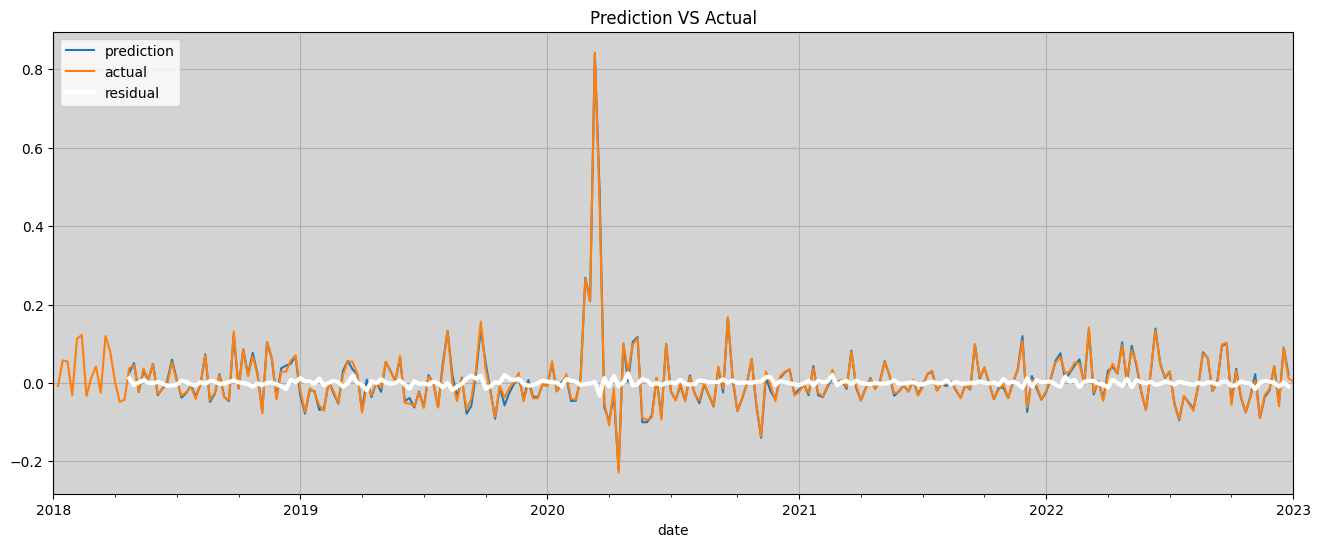

In [299]:
pred_cds.T.mean().plot(figsize=(16, 6), label='prediction')
R_cds.T.mean().plot(label='actual')
rsd_cds.T.mean().plot(linewidth=3, label='residual', color='white')
plt.title('Prediction VS Actual')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

### 2.2.a. CAPM:
#### $ r_{E}^{Equity} ∼ r^{mkt} + \epsilon $

In [16]:
tickers_eq = tickers[:-1]
def cpam_reg(returns, tickers_eq, window=16):
    beta = pd.DataFrame(index=returns.index[window:])
    for ticker in tickers_eq:
        ticker_returns = returns[[str(ticker) + "_eq", "SPY"]]
        for i in range(window, returns.shape[0]):
            Y = ticker_returns.loc[returns.index[i-window:i], str(ticker) + "_eq"]
            x = ticker_returns.loc[returns.index[i-window:i], "SPY"]
            results = OLS(Y, x,missing='drop').fit(params_only=True).params
            beta.loc[returns.index[i-1], str(ticker) + "_beta"] = results[0]
    return beta[:-2]

In [177]:
beta = cpam_reg(returns, tickers_eq)
beta.round(2)

,BA_beta,C_beta,DD_beta,F_beta,GE_beta,JPM_beta,LNC_beta,LOW_beta,LUV_beta,MAR_beta,NFLX_beta,T_beta,WFC_beta,XOM_beta,XRX_beta
date,,,,,,,,,,,,,,,
2018-04-25,0.82,0.82,1.55,0.26,0.29,0.72,0.96,0.95,0.91,1.09,2.11,0.24,1.20,1.22,1.36
2018-05-02,0.70,0.82,1.56,0.22,0.21,0.69,0.85,0.92,1.00,1.11,2.09,0.30,1.19,1.28,1.34
2018-05-09,0.62,0.95,1.60,0.36,0.56,0.78,0.82,0.67,0.78,1.09,2.16,0.20,1.26,1.33,1.08
2018-05-16,0.70,0.91,1.65,0.43,0.71,0.74,0.83,0.60,0.95,1.09,1.78,0.23,1.26,1.38,1.05
2018-05-23,0.78,0.89,1.64,0.39,0.67,0.73,0.84,0.65,0.90,1.10,1.84,0.24,1.27,1.38,1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.36,1.20,1.04,1.31,1.10,1.15,1.38,1.16,0.90,1.16,1.82,1.15,0.91,0.65,1.02
2022-12-07,0.38,1.28,0.98,1.32,1.02,1.15,1.48,1.07,0.97,1.18,1.69,1.05,1.06,0.74,1.00
2022-12-14,0.42,1.27,0.94,1.35,0.94,1.10,1.40,1.08,0.96,1.20,1.70,1.03,1.04,0.94,0.96


In [22]:
r_mkt = pd.concat([R_spy['2018-04-25':'2022-12-28']] * 15, axis=1)
r_mkt.columns = beta.columns

### 2.2.b. Predict equity return using betas from CPAM regression
#### $ {E}[\tilde{r}^{Equity}] = \beta_{Equity}^{(n)} \cdot r_{n}^{mkt}$

In [181]:
pred_eq = r_mkt * beta
pred_eq.columns = tickers_eq
pred_eq.round(3)

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-04-25,-0.020,-0.021,-0.039,-0.006,-0.007,-0.018,-0.024,-0.024,-0.023,-0.027,-0.053,-0.006,-0.030,-0.031,-0.034
2018-05-02,-0.001,-0.001,-0.003,-0.000,-0.000,-0.001,-0.001,-0.001,-0.002,-0.002,-0.003,-0.000,-0.002,-0.002,-0.002
2018-05-09,0.015,0.023,0.038,0.009,0.014,0.019,0.020,0.016,0.019,0.026,0.052,0.005,0.030,0.032,0.026
2018-05-16,0.007,0.009,0.017,0.004,0.007,0.007,0.008,0.006,0.010,0.011,0.018,0.002,0.013,0.014,0.011
2018-05-23,0.003,0.004,0.007,0.002,0.003,0.003,0.003,0.003,0.004,0.005,0.008,0.001,0.005,0.006,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.005,0.016,0.014,0.017,0.014,0.015,0.018,0.015,0.012,0.015,0.024,0.015,0.012,0.008,0.013
2022-12-07,-0.013,-0.046,-0.035,-0.047,-0.036,-0.041,-0.053,-0.038,-0.035,-0.042,-0.060,-0.037,-0.038,-0.026,-0.036
2022-12-14,0.007,0.020,0.015,0.021,0.015,0.017,0.022,0.017,0.015,0.019,0.027,0.016,0.016,0.015,0.015


### 2.2.c. Calculate equity residual return
#### $ c_{E,n} = r_{E,n}^{Equity} - {E}[\tilde{r}^{Equity}] $

In [183]:
rsd_equity = R_equity['2018-04-25':'2022-12-28'] - pred_eq
rsd_equity.round(3)

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-04-25,0.026,0.026,-0.026,0.000,0.036,0.024,0.039,-0.029,-0.013,0.020,-0.033,0.006,0.084,0.034,0.046
2018-05-02,-0.053,-0.018,0.000,0.009,0.010,-0.018,-0.057,0.032,-0.028,-0.021,0.028,-0.089,-0.015,-0.032,-0.039
2018-05-09,0.048,0.040,0.002,-0.022,0.018,0.032,-0.022,-0.011,-0.031,0.002,0.002,-0.025,0.008,0.009,-0.045
2018-05-16,-0.012,-0.009,0.013,0.026,0.021,-0.008,-0.003,0.007,0.018,0.007,-0.025,0.026,0.011,0.022,-0.020
2018-05-23,0.050,-0.027,-0.021,0.002,-0.059,-0.011,0.023,0.105,-0.054,-0.022,0.043,-0.000,0.015,-0.004,-0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.018,-0.012,-0.027,-0.026,-0.036,-0.003,-0.013,-0.008,0.021,0.009,0.024,-0.005,0.001,-0.028,0.022
2022-12-07,0.000,-0.032,0.024,-0.010,0.025,-0.008,-0.041,0.012,-0.018,-0.007,0.070,0.039,-0.077,-0.043,0.004
2022-12-14,0.060,0.009,-0.016,0.008,-0.056,-0.003,-0.104,0.008,-0.007,-0.006,0.003,-0.037,-0.023,0.012,0.019


### 2.2.d. Plot Prediction and Residual

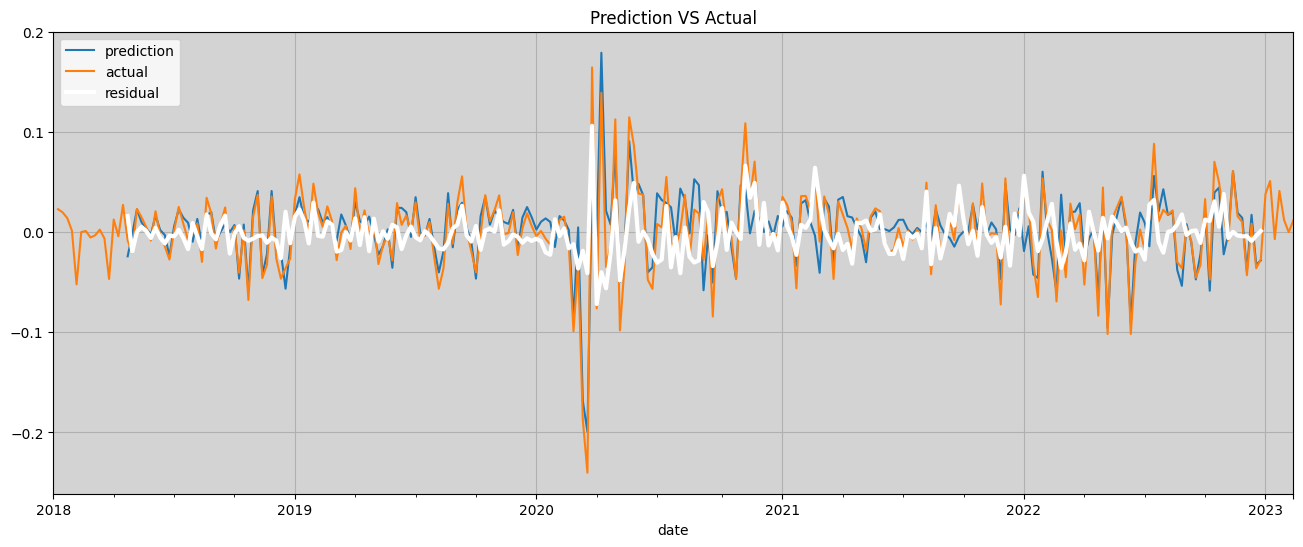

In [298]:
pred_eq.T.mean().plot(figsize=(16, 6), label='prediction')
R_equity.T.mean().plot(label='actual')
rsd_equity.T.mean().plot(linewidth=3, label='residual', color='white')
plt.title('Prediction VS Actual')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


### 2.3 Predicting residuals
#### $\rho_{E,n} ∼ c_{E,n-1} + ε $
#### $ q_{E,n} = ρ_{E,n} − μ_{E,n−1} \cdot c_{E,n−1} $

#### 2.3.1. Using bocar model

    a. get coeffs

In [212]:
df_rsd = rsd_equity.merge(rsd_cds, left_index=True, right_index=True, suffixes=["_eq","_cds"])

In [241]:
tickers_eq = tickers[:-1]
def boxcar_rsd_reg(df_rsd, tickers_eq, window=16):
    beta = pd.DataFrame(index=df_rsd.index[window:])
    for ticker in tickers_eq:
        df_rsd[str(ticker) + "_eq"].shift()
        for i in range(window, df_rsd.shape[0]):
            Y = df_rsd.loc[df_rsd.index[i-window:i], str(ticker) + "_cds"]
            x = df_rsd.loc[df_rsd.index[i-window:i], str(ticker) + "_eq"]
            results = OLS(Y, x).fit(params_only=True).params
            beta.loc[df_rsd.index[i-1], ticker] = results[0]
    return beta[:-2]

In [242]:
rsd_beta = boxcar_rsd_reg(df_rsd,tickers_eq)

In [245]:
rsd_beta.round(3)

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-08-15,-0.190,-0.377,0.225,-0.020,-0.098,-0.109,-0.122,-0.027,-0.221,0.223,NaN,-0.272,-0.452,-0.002,-0.974
2018-08-22,-0.250,-0.450,0.182,0.029,-0.098,-0.222,-0.316,0.039,-0.310,0.118,NaN,-0.428,-0.598,-0.140,0.187
2018-08-29,-0.321,-0.284,0.112,0.153,-0.120,0.056,-0.212,0.045,-0.302,0.108,NaN,-0.442,-0.383,-0.122,-0.157
2018-09-05,-0.401,-0.262,0.206,0.170,-0.084,0.075,-0.206,0.056,-0.285,0.190,NaN,-0.511,-0.352,-0.225,0.515
2018-09-12,-0.430,-0.267,0.198,0.192,-0.167,0.068,-0.217,-0.061,-0.353,0.334,NaN,-0.235,0.032,-0.149,0.607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23,-0.069,-0.421,0.091,-0.397,-0.308,0.030,-0.052,0.142,0.125,0.421,-0.016,-0.018,0.197,0.381,-0.506
2022-11-30,-0.053,-0.274,0.086,-0.458,-0.301,0.028,-0.041,0.121,0.108,0.389,-0.047,0.058,0.195,0.311,-0.432
2022-12-07,-0.064,-0.135,0.106,-0.485,-0.265,0.037,-0.015,-0.043,0.118,0.395,-0.034,0.034,0.099,0.218,-0.426


    b. Calculate residuals of the predictive model


In [250]:
c_lag1  = rsd_equity.shift().loc[rsd_beta.index]
q_boxcar = rsd_cds.loc[rsd_beta.index] - c_lag1 * rsd_beta
q_boxcar.round(3)

ticker,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
date,,,,,,,,,,,,,,,
2018-08-15,0.060,-0.003,0.039,-0.020,-0.013,0.002,0.016,0.009,0.026,0.068,NaN,-0.036,0.032,-0.002,-0.154
2018-08-22,0.017,-0.007,-0.024,0.047,-0.028,-0.009,0.002,-0.016,-0.034,0.053,NaN,-0.010,0.025,-0.009,0.031
2018-08-29,0.029,0.008,-0.039,0.033,0.007,-0.004,0.013,0.015,-0.024,0.012,NaN,-0.005,-0.010,0.003,0.031
2018-09-05,-0.016,0.009,-0.031,-0.007,-0.001,0.010,0.009,-0.006,-0.018,-0.040,NaN,0.019,-0.000,0.004,0.013
2018-09-12,0.018,-0.010,0.007,-0.005,-0.055,-0.011,-0.000,0.029,-0.022,0.045,NaN,0.041,-0.038,0.012,-0.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23,0.007,-0.010,-0.009,0.030,0.010,-0.016,0.057,-0.017,0.021,-0.003,0.046,-0.042,0.004,-0.012,-0.014
2022-11-30,0.050,-0.038,0.014,-0.007,0.022,-0.007,-0.014,0.042,-0.001,-0.010,0.009,-0.062,-0.017,0.055,0.021
2022-12-07,-0.021,-0.018,0.025,0.003,0.016,0.000,-0.095,0.029,-0.006,-0.002,0.040,-0.025,0.008,0.055,-0.009


#### 2.3.2. Using exponential model


    a. get coeffs

In [251]:
half_life = 12
lma = 2**(-1./half_life)
threshold = 1. / (df_rsd.shape[0] * 10)
print(f"Lambda: {lma}  -> Truncation threshold {threshold}")

w12 = lma**np.arange(df_rsd.shape[0]-1, -1, -1)

# Cuts off weight values too small to care about, allowing use of naive routines without losing accuracy or having too many points
exp_1p2_wts = w12[ w12 > threshold]
print(f"""
Full weight at start and finish:\n{w12[[0,1, -2, -1]]} N={w12.shape[0]}

Truncated at start and finish:\n{exp_1p2_wts[[0,1, -2, -1]]}  N={exp_1p2_wts.shape[0]}
""")

enough_points = np.where(w12 > threshold)[0].shape[0]
print(enough_points)

def exp_1_2_reg(_df, tickers_eq):
    _n = min(exp_1p2_wts.shape[0], _df.shape[0])
    _ldf = _df.iloc[-_n:]
    _wt = exp_1p2_wts[-_n:]
    results = {}
    for ticker in tickers_eq:
        _ldf[str(ticker) + "_eq"].shift()
        _p = linreg.WLS(_ldf[str(ticker) + '_cds'], _ldf[str(ticker) + '_eq'], weights=_wt).fit(params_only=True).params
        results[ticker] = _p[0]
    return pd.DataFrame(data=results, index=[_df.index[-1]])

Lambda: 0.9438743126816935  -> Truncation threshold 0.00040816326530612246

Full weight at start and finish:
[7.56931807e-07 8.01941314e-07 9.43874313e-01 1.00000000e+00] N=245

Truncated at start and finish:
[4.10593953e-04 4.35009140e-04 9.43874313e-01 1.00000000e+00]  N=136

136


In [252]:
exp_coeffs = pd.concat([exp_1_2_reg(df_rsd[max(0,i-exp_1p2_wts.shape[0]):i],tickers_eq) for i in range(enough_points, df_rsd.shape[0])])
exp_coeffs.round(3)

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
2020-11-25,-0.255,0.144,0.078,0.020,-0.041,0.329,-0.047,-0.239,-0.450,-0.231,NaN,-0.038,0.119,-0.124,0.229
2020-12-02,-0.261,0.135,0.019,0.017,-0.018,0.295,-0.046,-0.265,-0.362,-0.190,NaN,-0.038,0.116,-0.102,0.209
2020-12-09,-0.334,0.148,0.164,0.014,0.047,0.278,-0.048,0.103,-0.308,-0.209,NaN,-0.123,0.117,-0.091,0.206
2020-12-16,-0.333,0.148,0.163,0.038,0.102,0.283,-0.040,0.107,-0.334,-0.214,NaN,-0.037,0.117,-0.096,0.212
2020-12-23,-0.350,0.164,0.125,0.036,0.102,0.315,-0.040,0.113,-0.313,-0.227,NaN,0.032,0.132,-0.065,0.218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23,-0.172,-0.046,0.020,-0.266,-0.107,0.005,-0.048,0.033,-0.026,0.114,-0.034,0.002,0.116,0.127,-0.205
2022-11-30,-0.153,-0.016,0.001,-0.259,-0.131,0.007,-0.046,0.018,-0.027,0.104,-0.030,0.012,0.115,0.065,-0.190
2022-12-07,-0.153,0.023,0.024,-0.264,-0.095,0.007,-0.015,0.036,-0.023,0.104,-0.001,-0.022,0.048,-0.018,-0.193
2022-12-14,-0.147,0.028,0.058,-0.242,0.008,0.003,0.020,0.015,-0.012,0.111,-0.001,-0.024,0.024,-0.015,-0.205


    b. Calculate residuals of the predictive model


In [253]:
c_lag = rsd_equity.shift().loc[exp_coeffs.index]
rho = rsd_cds.loc[exp_coeffs.index]
q_exp = rho - exp_coeffs * c_lag
q_exp.round(3)

ticker,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX
2020-11-25,0.000,0.002,0.059,0.015,0.018,0.034,-0.000,0.075,0.055,0.021,NaN,-0.009,-0.003,0.017,-0.047
2020-12-02,-0.056,0.025,0.056,-0.016,-0.067,0.049,0.017,0.046,-0.121,-0.083,NaN,-0.002,0.018,-0.008,-0.000
2020-12-09,-0.182,0.026,0.065,-0.003,0.043,0.048,-0.007,0.222,-0.071,-0.082,NaN,-0.021,0.010,-0.005,-0.003
2020-12-16,0.026,-0.003,-0.015,-0.019,-0.081,-0.009,-0.006,0.007,0.111,0.021,NaN,-0.029,-0.001,-0.009,-0.039
2020-12-23,0.054,0.034,-0.052,0.015,0.004,0.033,-0.037,-0.086,0.026,0.065,NaN,-0.024,0.025,-0.019,-0.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23,0.006,-0.010,-0.010,0.034,0.018,-0.017,0.057,-0.007,0.018,0.002,0.048,-0.041,0.000,-0.010,-0.020
2022-11-30,0.051,-0.032,0.016,-0.004,0.019,-0.007,-0.013,0.038,-0.001,-0.015,0.011,-0.062,-0.017,0.054,0.017
2022-12-07,-0.019,-0.016,0.023,0.009,0.022,0.000,-0.095,0.030,-0.003,0.000,0.039,-0.026,0.008,0.048,-0.014
2022-12-14,-0.004,0.009,-0.049,0.070,-0.035,0.017,-0.042,-0.047,-0.031,-0.020,-0.010,0.003,0.020,0.005,-0.019


## 3. Analysis

### a. Boxcar Model Performance for predicting CDS spread return Analysis

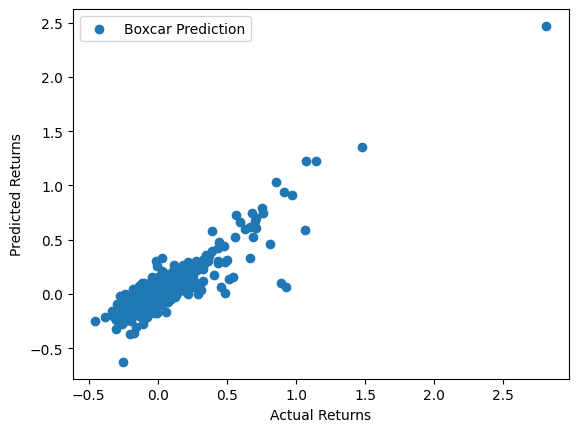

In [136]:
plt.scatter(R_cds.loc[pred_cds.index], pred_cds, label='Boxcar Prediction')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.legend()
plt.show()

In [157]:
def boxcar_reg_performance(returns, tickers_eq, window=16):
    boxcar_coeffs = pd.DataFrame(index=returns.index[window:])
    resquared = pd.Series(index=returns.index[window:])
    treynor_ratio = pd.Series(index=returns.index[window:])
    tracking_error = pd.Series(index=returns.index[window:])
    
    for ticker in tickers_eq:
        ticker_returns = returns[[str(ticker) + "_eq", str(ticker) + "_cds", "cds_index"]]
        for i in range(window, returns.shape[0]):
            x = ticker_returns.loc[returns.index[i-window:i], [str(ticker) + "_eq", "cds_index"]]
            y = ticker_returns.loc[returns.index[i-window:i], str(ticker) + "_cds"]
            mask = ~(y.isna() | x.isna()).any(axis=1)
            Y_clean = y.loc[mask]
            x_clean = x.loc[mask]
            results = OLS(Y_clean, x_clean).fit(params_only=True)
            boxcar_coeffs.loc[returns.index[i-1], str(ticker) + "_cds_eq"] = results.params[0]
            boxcar_coeffs.loc[returns.index[i-1], str(ticker) + "_cds_index"] = results.params[1]
            
            # calculate resquared, Treynor ratio, and tracking error
            y_pred = results.predict(x_clean)
            residuals = Y_clean - y_pred
            resquared.loc[returns.index[i-1]] = 1 - residuals.var() / Y_clean.var()
            treynor_ratio.loc[returns.index[i-1]] = results.params[0] / x_clean[str(ticker) + "_eq"].std()
            tracking_error.loc[returns.index[i-1]] = residuals.std()
            
    results_table = pd.concat([resquared, treynor_ratio, tracking_error], axis=1)
    results_table.columns = ['resquared', 'treynor_ratio', 'tracking_error']
    return results_table[:-2]


In [167]:
boxcar_summary = boxcar_reg_performance(returns, tickers_eq)
boxcar_summary.describe().round(2)

,resquared,treynor_ratio,tracking_error
count,245.00,245.00,245.00
mean,0.57,-4.54,0.06
std,0.18,10.29,0.03
min,0.10,-57.69,0.02
25%,0.46,-7.06,0.03
50%,0.60,-4.13,0.05
75%,0.71,-1.42,0.06
max,0.86,23.79,0.18


Comment:

Based on the statistics, the resquared metric has a mean of 0.57 and a standard deviation of 0.18. This suggests that the model explains around 57% of the variance in the dependent variable on average, which is relatively good, but with a fair amount of variability in its performance.

The treynor_ratio has a mean of -4.54 and a standard deviation of 10.29. A negative mean suggests that the model is underperforming compared to the market, while the large standard deviation indicates a high variability in performance. The minimum value of -57.69 is quite low, indicating that the model has periods of severe underperformance compared to the market.

The tracking_error metric has a mean of 0.06 and a standard deviation of 0.03, which is relatively low, suggesting that the model is tracking the benchmark closely. The maximum value of 0.183263 is still quite low, which is a positive sign.

Overall, based solely on these statistics, it is difficult to make a definitive conclusion about the performance of the Boxcar model. However, the relatively high resquared and low tracking_error metrics suggest that the model is doing a reasonably good job of tracking the benchmark, but the poor treynor_ratio suggests that the model is not generating sufficient returns to compensate for its risk. 

Plot predicted values against actual values

### b. CAPM Model Performance for predicting equity return Analysis

In [187]:
def cpam_reg(returns, tickers_eq, window=16):
    beta = pd.DataFrame(index=returns.index[window:])
    r2 = pd.DataFrame(index=returns.index[window:])
    mse = pd.DataFrame(index=returns.index[window:])
    for ticker in tickers_eq:
        ticker_returns = returns[[str(ticker) + "_eq", "SPY"]]
        for i in range(window, returns.shape[0]):
            Y = ticker_returns.loc[returns.index[i-window:i], str(ticker) + "_eq"]
            x = ticker_returns.loc[returns.index[i-window:i], "SPY"]
            results = OLS(Y, x,missing='drop').fit()
            beta.loc[returns.index[i-1], str(ticker) + "_beta"] = results.params[0]
            r2.loc[returns.index[i-1], str(ticker) + "_r2"] = results.rsquared
            mse.loc[returns.index[i-1], str(ticker) + "_mse"] = results.mse_resid
    return r2[:-2], mse[:-2]
r2, mse = cpam_reg(returns, tickers_eq)

In [193]:
r2.describe().round(4)

,BA_r2,C_r2,DD_r2,F_r2,GE_r2,JPM_r2,LNC_r2,LOW_r2,LUV_r2,MAR_r2,NFLX_r2,T_r2,WFC_r2,XOM_r2,XRX_r2
count,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000
mean,0.3318,0.4640,0.4315,0.3344,0.2914,0.4758,0.4643,0.4100,0.3315,0.4528,0.3109,0.1955,0.3762,0.3659,0.4289
std,0.2102,0.2623,0.2538,0.2115,0.2445,0.2087,0.2253,0.2015,0.1985,0.1876,0.1809,0.1692,0.2132,0.2540,0.1948
min,0.0002,0.0028,0.0000,0.0000,0.0000,0.0006,0.0014,0.0151,0.0000,0.0123,0.0001,0.0001,0.0029,0.0001,0.0193
25%,0.1417,0.2295,0.2201,0.1869,0.0760,0.2993,0.2869,0.2520,0.1865,0.3263,0.1773,0.0522,0.2127,0.1714,0.2659
50%,0.3603,0.4636,0.4531,0.2651,0.2321,0.4871,0.4599,0.4006,0.3506,0.4550,0.3019,0.1619,0.3672,0.3280,0.4670
75%,0.5008,0.7017,0.6696,0.5058,0.5012,0.6319,0.6238,0.5499,0.4688,0.5995,0.4329,0.2882,0.5128,0.5612,0.5888
max,0.8146,0.9655,0.8641,0.8378,0.7914,0.8690,0.8961,0.9282,0.7184,0.8594,0.7748,0.6884,0.8369,0.9165,0.8273


In [192]:
mse.describe().round(4)

,BA_mse,C_mse,DD_mse,F_mse,GE_mse,JPM_mse,LNC_mse,LOW_mse,LUV_mse,MAR_mse,NFLX_mse,T_mse,WFC_mse,XOM_mse,XRX_mse
count,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000,245.0000
mean,0.0032,0.0012,0.0013,0.0020,0.0026,0.0008,0.0021,0.0012,0.0019,0.0019,0.0030,0.0010,0.0013,0.0011,0.0020
std,0.0052,0.0008,0.0009,0.0013,0.0019,0.0005,0.0022,0.0013,0.0017,0.0023,0.0025,0.0007,0.0010,0.0007,0.0015
min,0.0007,0.0002,0.0002,0.0003,0.0006,0.0001,0.0003,0.0001,0.0002,0.0003,0.0005,0.0001,0.0001,0.0002,0.0002
25%,0.0013,0.0005,0.0007,0.0010,0.0012,0.0004,0.0009,0.0006,0.0009,0.0006,0.0017,0.0005,0.0006,0.0004,0.0010
50%,0.0016,0.0010,0.0010,0.0016,0.0019,0.0007,0.0013,0.0010,0.0015,0.0013,0.0023,0.0007,0.0009,0.0010,0.0018
75%,0.0024,0.0015,0.0016,0.0025,0.0034,0.0011,0.0024,0.0012,0.0021,0.0024,0.0032,0.0012,0.0019,0.0017,0.0023
max,0.0242,0.0035,0.0042,0.0056,0.0082,0.0021,0.0108,0.0068,0.0090,0.0109,0.0135,0.0029,0.0042,0.0025,0.0079


Comment:

In the performance table you provided, the R2 values range from 0 to 0.9655, with an average value of 0.3827. The R2 values are relatively low, which may suggest that the CAPM model is not the best fit for these stocks. However, it's important to consider other factors, such as the number of data points and the specific characteristics of the data set, before drawing any conclusions about the model's performance.

The mean MSE values range from 0.0008 to 0.0032, with the lowest value belonging to GE and the highest belonging to JPM. This means that the model performed best in predicting the stock price of GE, and worst in predicting the stock price of JPM.

The standard deviation of the MSE values ranges from 0.0005 to 0.0052, with the lowest value belonging to LOW and the highest belonging to BA. A low standard deviation indicates that the values are clustered around the mean, while a high standard deviation indicates that the values are more spread out.

Based on the provided MSE values for each stock, the overall performance based on MSE can be summarized as follows:

Mean MSE: 0.0019
Standard deviation of MSE: 0.0017
Minimum MSE: 0.0002
Maximum MSE: 0.0242

This suggests that on average, the predicted values are 0.0019 away from the true values for the given stocks, and there is a fair amount of variability in the prediction accuracy across the different stocks. 

### c. Boxcar VS. Exponential regression models for predicting residuals

The point of calculating the residuals in this analysis is to use them as inputs for predictive regression models. The residuals capture the portion of the CDS spread return that cannot be explained by the contemporaneous predictors (equity and CDS index returns). By using past residuals of the equity returns to predict novel changes in the residuals of the CDS spread returns, the predictive regression models aim to capture additional information that is not explained by the contemporaneous predictors.

        Tails?

In [307]:
boxcar_rsd_summary = q_boxcar.describe().round(3).T
boxcar_rsd_summary['Kurtosis'] = q_boxcar.kurtosis().round(3)
boxcar_rsd_summary['Skew'] = q_boxcar.skew().round(3)
boxcar_rsd_summary

,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skew
ticker,,,,,,,,,,
BA,228.0,-0.000,0.072,-0.327,-0.029,-0.005,0.029,0.331,6.983,0.492
C,228.0,0.002,0.040,-0.304,-0.013,0.000,0.015,0.263,22.604,-0.699
DD,228.0,-0.001,0.077,-0.300,-0.032,0.004,0.028,0.802,53.044,4.542
F,228.0,0.001,0.057,-0.192,-0.024,-0.005,0.023,0.465,19.621,2.316
GE,228.0,0.001,0.059,-0.192,-0.025,-0.000,0.023,0.235,2.714,0.056
JPM,228.0,0.002,0.039,-0.247,-0.016,-0.002,0.017,0.213,11.636,-0.184
LNC,228.0,-0.002,0.036,-0.294,-0.018,-0.002,0.018,0.079,21.759,-2.939
LOW,228.0,0.003,0.057,-0.161,-0.025,-0.003,0.026,0.502,26.215,3.125
LUV,228.0,-0.002,0.078,-0.255,-0.026,-0.005,0.014,0.805,54.230,5.448


In [308]:
exp_rsd_summary = q_exp.describe().round(3).T
exp_rsd_summary['Kurtosis'] = q_exp.kurtosis().round(3)
exp_rsd_summary['Skew'] = q_exp.skew().round(3)
exp_rsd_summary

,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skew
ticker,,,,,,,,,,
BA,109.0,-0.006,0.042,-0.182,-0.023,-0.009,0.011,0.132,3.456,-0.031
C,109.0,0.002,0.021,-0.059,-0.010,-0.000,0.011,0.072,1.313,0.193
DD,109.0,0.005,0.031,-0.070,-0.016,0.004,0.022,0.089,0.011,0.108
F,109.0,0.003,0.036,-0.109,-0.018,-0.000,0.022,0.115,0.884,0.228
GE,109.0,-0.003,0.033,-0.133,-0.020,-0.003,0.018,0.108,2.255,-0.295
JPM,109.0,0.001,0.022,-0.069,-0.010,-0.000,0.012,0.056,1.540,-0.282
LNC,109.0,0.002,0.026,-0.095,-0.012,0.001,0.017,0.080,2.298,-0.041
LOW,109.0,0.005,0.045,-0.106,-0.020,0.002,0.030,0.222,4.282,0.982
LUV,109.0,-0.007,0.043,-0.129,-0.031,-0.007,0.011,0.189,3.954,0.717


Comment:

In general, the boxcar model with a 16-week window would perform better when the return distribution is relatively symmetric and with low kurtosis, while the exponential model would be better suited for distributions with high skewness and kurtosis.

Based on the skewness and kurtosis data from the Boxcar performance stats, we can see that some stocks have relatively high kurtosis and skewness values, which suggests that an exponential model may perform better for these stocks. For example, the stocks LNC, LUV, and DD have high kurtosis and skewness values, indicating that their return distributions are more heavy-tailed and asymmetric than the other stocks in the list.

On the other hand, some stocks have low kurtosis and skewness values, which suggests that a boxcar model may perform better for these stocks. For example, the stocks GE and T have relatively low kurtosis and skewness values, indicating that their return distributions are more symmetric and have less tail heaviness compared to the other stocks.

Comparing the two tables, we can see that the exponential regression model generally has smaller mean and standard deviation of the residuals, indicating better performance in predicting stock prices. Moreover, the exponential regression model has lower values of kurtosis and skewness, indicating a more normal distribution of residuals, compared to the boxcar model.

        Plot residual mean

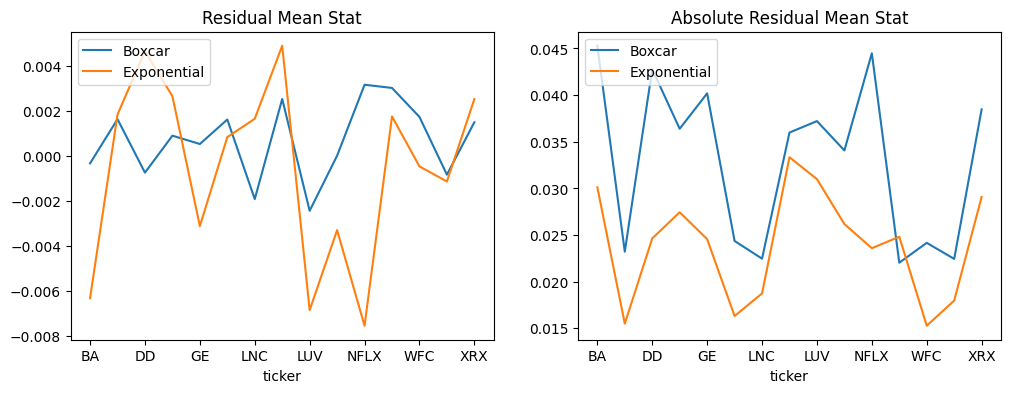

In [300]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the mean residual for boxcar and exponential regression models
q_boxcar.describe().iloc[1].plot(ax=ax[0], label='Boxcar')
q_exp.describe().iloc[1].plot(ax=ax[0], label='Exponential')
ax[0].set_title('Residual Mean Stat')
ax[0].legend(loc='upper left')

# Plot the absolute mean residual for boxcar and exponential regression models
abs(q_boxcar).describe().iloc[1].plot(ax=ax[1], label='Boxcar')
abs(q_exp).describe().iloc[1].plot(ax=ax[1], label='Exponential')
ax[1].set_title('Absolute Residual Mean Stat')
ax[1].legend(loc='upper left')

# Show the figure
plt.show()

Comment:

The mean residual values for both methods are close to zero for most of the stocks, with some exceptions where the mean residual values are negative for the exponential method.
The standard deviation of the residuals for the exponential method is generally smaller than that of the boxcar method, indicating that the exponential method provides better smoothing of the data.
The minimum and maximum residual values for both methods are comparable, with some exceptions where the maximum residual value for the exponential method is smaller than that of the boxcar method.
Overall, the residual stats suggest that the exponential method is better at smoothing the time series data, providing a more accurate representation of the underlying trend. However, the choice of method depends on the specific application and the nature of the data being analyzed.

        Using QQ plot to assess the normality assumption of the risduals

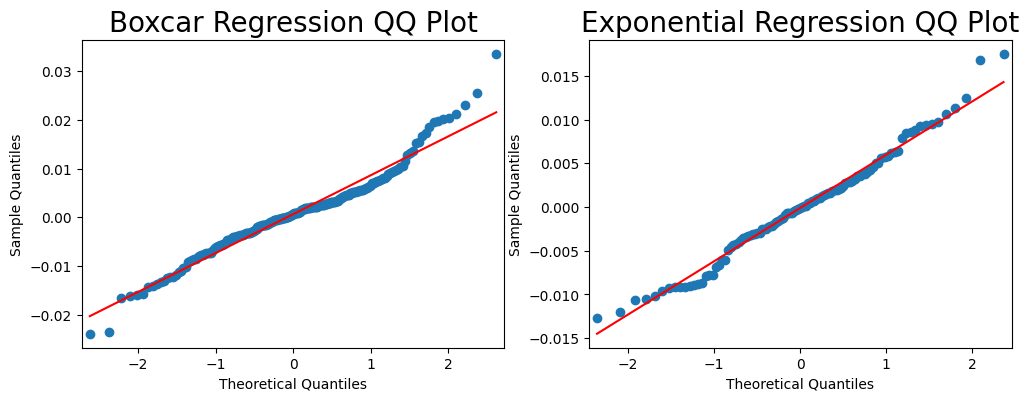

In [281]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the Boxcar regression QQ plot in the first subplot
sm.qqplot(q_boxcar.mean(axis=1), line='s', ax=ax[0])
ax[0].set_title('Boxcar Regression QQ Plot', fontsize=20)

# Plot the Exponential regression QQ plot in the second subplot
sm.qqplot(q_exp.mean(axis=1), line='s', ax=ax[1])
ax[1].set_title('Exponential Regression QQ Plot', fontsize=20)

# Show the figure
plt.show()

Comment:

In the context of regression analysis, the residuals represent the difference between the actual values and the predicted values of the response variable. If the errors in the model (which the residuals represent) are normally distributed, then the distribution of the predicted values will also be normal. This is because the predicted values are calculated as the sum of the intercept, the product of the coefficients and the predictor variables, and the error term, which is assumed to be normally distributed.

Assuming normality of the residuals is important for several reasons. First, it enables us to make accurate predictions and estimate confidence intervals for those predictions. Second, it allows us to use statistical inference techniques, such as hypothesis testing and confidence intervals, that assume normality of the errors. Finally, it helps us to identify potential issues with the model, such as heteroscedasticity or skewness in the residuals.

A QQ plot is a graphical method for assessing the normality assumption of the residuals in a regression model. The closer the points on the plot are to a straight line, the more closely the distribution of the residuals approximates a normal distribution. Based on the plots above, the exponential regression model has residuals that are more closely aligned to a straight line, it indicates that the distribution of the residuals in this model is closer to normal than in the other model.

### d. Possible explanations why exponential model might work better than boxcar model
    Historical events:

Starting with COVID-19, the pandemic caused widespread economic disruption and uncertainty, which had a significant impact on financial markets. For example, in early 2020, global stock markets experienced a sharp drop as investors reacted to the uncertainty surrounding the pandemic. This drop was followed by a strong recovery in equity prices in the latter half of 2020, as governments and central banks around the world implemented various measures to support economic growth and provide liquidity to financial markets.

The impact of COVID-19 on equity returns and spreads could potentially affect the performance of both boxcar and exponential regression models. In the case of boxcar regression, the model assumes that the underlying process generating the data is stationary, meaning that its statistical properties remain constant over time. However, if the impact of COVID-19 on equity returns and spreads has caused changes in the underlying process, then the assumptions of the boxcar model may no longer hold, and the model may not perform as well in predicting future equity returns and spreads.

Similarly, the impact of COVID-19 on equity returns and spreads could also affect the performance of exponential regression models. Exponential regression models assume that the relationship between the independent and dependent variables is exponential, which may not hold if the impact of COVID-19 has caused sudden and significant changes in the underlying process.

Moving on to the conflict in Ukraine, the ongoing conflict has had a number of economic and political implications, including potential impacts on equity returns and spreads. For example, geopolitical tensions and uncertainty can cause investors to reassess their risk appetite and adjust their portfolios, which could in turn affect equity returns and spreads.

Again, these potential effects of the conflict on equity returns and spreads could impact the performance of regression models like boxcar and exponential regression. If the conflict has caused sudden and significant changes in the underlying process generating the data, then the assumptions of these models may no longer hold, and they may not perform as well in predicting future equity returns and spreads.

    Why exponential model performs better?

One possible reason why the exponential model may perform better than the boxcar model during times of significant market events is that the exponential model puts more weight on recent observations than older ones. This means that as new data becomes available, the exponential model will update its prediction faster than the boxcar model, which gives equal weight to all observations within the window.

During times of significant market events, market conditions can change rapidly and unexpectedly, so it can be important to have a model that can adapt quickly to new information. The exponential model's ability to give more weight to recent data can make it better suited to capturing these rapid changes and providing more accurate predictions.

Furthermore, the exponential model's ability to capture trends and changes in the underlying data can be particularly useful during times of significant market events. For example, during the COVID-19 pandemic, the exponential model's ability to capture the exponential growth of cases and deaths could have made it better suited to predicting the market impact of the pandemic than the boxcar model, which would have given equal weight to all observations within the window. Similarly, during the Ukraine conflict, the exponential model's ability to capture the rapidly changing geopolitical landscape could have made it better suited to predicting the market impact of the conflict than the boxcar model.

    Cases when exponential model underperform?

In general, the exponential model may underperform the boxcar model if the underlying data is more volatile or if the trends in the data are more short-lived. In such cases, the boxcar model with a larger window size may be better suited to capture the longer-term trends in the data, whereas the exponential model may be more sensitive to short-term fluctuations and noise.

It's also worth noting that the choice of regression model depends on the specific goals of the analysis and the preferences of the researcher. While the exponential model may have performed better than the boxcar model in the context of the COVID-19 pandemic and the Ukraine crisis, it may not necessarily be the best choice for other types of data and historical events. Ultimately, the best approach is to use a range of models and compare their performance on the specific data at hand.

While exponential models can be more robust to certain types of events, there are situations where they may underperform compared to boxcar models. Here are a few examples:

Sudden and unexpected shocks to the economy: If there is a sudden and unexpected shock to the economy, such as a terrorist attack or natural disaster, the exponential model may struggle to capture the full impact of the event. In such situations, the boxcar model may be better able to capture the sudden shift in the data.

Periods of low volatility: During periods of low volatility, the exponential model may overestimate the magnitude of changes in the data. This can lead to overconfident predictions and potentially poor performance. In such situations, the boxcar model may be more appropriate as it can smooth out the noise in the data.

Changes in trend: If there is a significant change in the trend of the data, the exponential model may struggle to adapt quickly enough. This is because the exponential model assumes that the trend will continue indefinitely, which may not always be the case. In contrast, the boxcar model can adjust to changes in trend more quickly by adjusting the window size.